<a href="https://colab.research.google.com/github/Aygle/NLP_Classification_de_Commentaire/blob/main/Classification_commentaires_toxiques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Import Regex to clean up comments
import re

import nltk, string
from nltk.corpus import stopwords

from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import GRU, Dense, Embedding
from tensorflow.keras import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [ ]:
full_data_size = len(data)
full_data_size

159571

Reduction d'élément au hasard du dataset (pour faciliter le fit du modèle)




In [ ]:
data_size = int(len(data)*0.25)
data_size

7978

In [ ]:
remove_n_rows = len(data) - data_size
drop_indices = np.random.choice(data.index, remove_n_rows, replace=False)
data = data.drop(drop_indices)
print("La nouvelle taille du dataset est de : {} \nAu lieu de : {} ".format(len(data), full_data_size))

La nouvelle taille du dataset est de : 7978 
Au lieu de : 159571 


# Etude du jeu de données

Il n'y a pas de valeur undefine

In [ ]:
data.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [ ]:
max_length = data['comment_text'].apply(lambda x : len(x.split())).max()
print("Taille du commentaire le plus long : {}".format(max_length))

# en triant tous les commentaire, on deduit le plus long 
# data.sort_values(by="comment_text", key=lambda x: x.str.len(),ascending=False)

Taille du commentaire le plus long : 982


In [ ]:
average_size = int(data['comment_text'].apply(lambda x : len(x.split())).mean())
print("Taille Moyenne d'un commentaire : {} ".format(average_size))

Taille Moyenne d'un commentaire : 67 


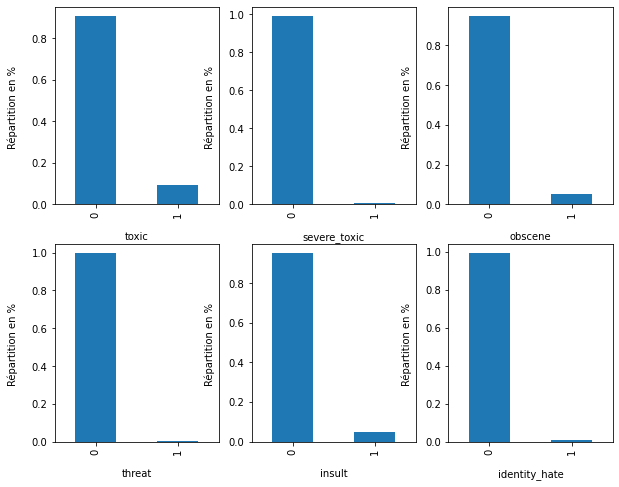

In [ ]:
fig = plt.figure(figsize=(10, 8))
for i in range(6):
    fig.add_subplot(2, 3, i+1)
    data.iloc[:,i + 2].value_counts(normalize=True).plot(kind='bar')
    plt.xlabel(data.iloc[:,i + 2].name, labelpad=14)
    plt.ylabel("Répartition en % ", labelpad=14)

In [ ]:
comments = data.drop(['id','comment_text'],axis = 1)
for i in comments.columns :
    print("Percent of {0}s: ".format(i), round(100*comments[i].mean(),2), "%")

Percent of toxics:  9.34 %
Percent of severe_toxics:  0.92 %
Percent of obscenes:  5.33 %
Percent of threats:  0.3 %
Percent of insults:  5.03 %
Percent of identity_hates:  0.76 %


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


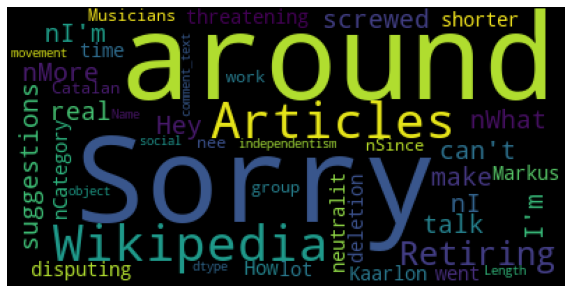

In [ ]:
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
wordcloud = WordCloud(stopwords=stopwords.words('english'),max_words=50).generate(str(data.comment_text))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Préparation des données

## Nettoyage des Commentaires


### On crée une fonction pour nettoyer les tweets. Les contractions sont séparées, les caractères spéciaux sont supprimés, ainsi que les URL, les mentions, les mots trop courts et les mots vides.


In [ ]:
def clean(comment): 
            
    # Contractions
    comment = re.sub(r"he's", "he is", comment)
    comment = re.sub(r"there's", "there is", comment)
    comment = re.sub(r"We're", "We are", comment)
    comment = re.sub(r"That's", "That is", comment)
    comment = re.sub(r"won't", "will not", comment)
    comment = re.sub(r"they're", "they are", comment)
    comment = re.sub(r"Can't", "Cannot", comment)
    comment = re.sub(r"wasn't", "was not", comment)
    comment = re.sub(r"don\x89Ûªt", "do not", comment)
    comment = re.sub(r"aren't", "are not", comment)
    comment = re.sub(r"isn't", "is not", comment)
    comment = re.sub(r"What's", "What is", comment)
    comment = re.sub(r"haven't", "have not", comment)
    comment = re.sub(r"hasn't", "has not", comment)
    comment = re.sub(r"There's", "There is", comment)
    comment = re.sub(r"He's", "He is", comment)
    comment = re.sub(r"It's", "It is", comment)
    comment = re.sub(r"You're", "You are", comment)
    comment = re.sub(r"I'M", "I am", comment)
    comment = re.sub(r"shouldn't", "should not", comment)
    comment = re.sub(r"wouldn't", "would not", comment)
    comment = re.sub(r"i'm", "I am", comment)
    comment = re.sub(r"I\x89Ûªm", "I am", comment)
    comment = re.sub(r"I'm", "I am", comment)
    comment = re.sub(r"Isn't", "is not", comment)
    comment = re.sub(r"Here's", "Here is", comment)
    comment = re.sub(r"you've", "you have", comment)
    comment = re.sub(r"you\x89Ûªve", "you have", comment)
    comment = re.sub(r"we're", "we are", comment)
    comment = re.sub(r"what's", "what is", comment)
    comment = re.sub(r"couldn't", "could not", comment)
    comment = re.sub(r"we've", "we have", comment)
    comment = re.sub(r"it\x89Ûªs", "it is", comment)
    comment = re.sub(r"doesn\x89Ûªt", "does not", comment)
    comment = re.sub(r"It\x89Ûªs", "It is", comment)
    comment = re.sub(r"Here\x89Ûªs", "Here is", comment)
    comment = re.sub(r"who's", "who is", comment)
    comment = re.sub(r"I\x89Ûªve", "I have", comment)
    comment = re.sub(r"y'all", "you all", comment)
    comment = re.sub(r"can\x89Ûªt", "cannot", comment)
    comment = re.sub(r"would've", "would have", comment)
    comment = re.sub(r"it'll", "it will", comment)
    comment = re.sub(r"we'll", "we will", comment)
    comment = re.sub(r"wouldn\x89Ûªt", "would not", comment)
    comment = re.sub(r"We've", "We have", comment)
    comment = re.sub(r"he'll", "he will", comment)
    comment = re.sub(r"Y'all", "You all", comment)
    comment = re.sub(r"Weren't", "Were not", comment)
    comment = re.sub(r"Didn't", "Did not", comment)
    comment = re.sub(r"they'll", "they will", comment)
    comment = re.sub(r"they'd", "they would", comment)
    comment = re.sub(r"DON'T", "DO NOT", comment)
    comment = re.sub(r"That\x89Ûªs", "That is", comment)
    comment = re.sub(r"they've", "they have", comment)
    comment = re.sub(r"i'd", "I would", comment)
    comment = re.sub(r"should've", "should have", comment)
    comment = re.sub(r"You\x89Ûªre", "You are", comment)
    comment = re.sub(r"where's", "where is", comment)
    comment = re.sub(r"Don\x89Ûªt", "Do not", comment)
    comment = re.sub(r"we'd", "we would", comment)
    comment = re.sub(r"i'll", "I will", comment)
    comment = re.sub(r"weren't", "were not", comment)
    comment = re.sub(r"They're", "They are", comment)
    comment = re.sub(r"Can\x89Ûªt", "Cannot", comment)
    comment = re.sub(r"you\x89Ûªll", "you will", comment)
    comment = re.sub(r"I\x89Ûªd", "I would", comment)
    comment = re.sub(r"let's", "let us", comment)
    comment = re.sub(r"it's", "it is", comment)
    comment = re.sub(r"can't", "cannot", comment)
    comment = re.sub(r"don't", "do not", comment)
    comment = re.sub(r"you're", "you are", comment)
    comment = re.sub(r"i've", "I have", comment)
    comment = re.sub(r"that's", "that is", comment)
    comment = re.sub(r"i'll", "I will", comment)
    comment = re.sub(r"doesn't", "does not", comment)
    comment = re.sub(r"i'd", "I would", comment)
    comment = re.sub(r"didn't", "did not", comment)
    comment = re.sub(r"ain't", "am not", comment)
    comment = re.sub(r"you'll", "you will", comment)
    comment = re.sub(r"I've", "I have", comment)
    comment = re.sub(r"Don't", "do not", comment)
    comment = re.sub(r"I'll", "I will", comment)
    comment = re.sub(r"I'd", "I would", comment)
    comment = re.sub(r"Let's", "Let us", comment)
    comment = re.sub(r"you'd", "You would", comment)
    comment = re.sub(r"It's", "It is", comment)
    comment = re.sub(r"Ain't", "am not", comment)
    comment = re.sub(r"Haven't", "Have not", comment)
    comment = re.sub(r"Could've", "Could have", comment)
    comment = re.sub(r"youve", "you have", comment)  
    comment = re.sub(r"donå«t", "do not", comment)
    comment =  comment.lower()
    comment = re.sub(r"i'm", "i am", comment)
    comment = re.sub(r"\r", "", comment)
    comment = re.sub(r"he's", "he is", comment)
    comment = re.sub(r"she's", "she is", comment)
    comment = re.sub(r"it's", "it is", comment)
    comment = re.sub(r"that's", "that is", comment)
    comment = re.sub(r"what's", "that is", comment)
    comment = re.sub(r"where's", "where is", comment)
    comment = re.sub(r"how's", "how is", comment)
    comment = re.sub(r"\'ll", " will", comment)
    comment = re.sub(r"\'ve", " have", comment)
    comment = re.sub(r"\'re", " are", comment)
    comment = re.sub(r"\'d", " would", comment)
    comment = re.sub(r"\'re", " are", comment)
    comment = re.sub(r"won't", "will not", comment)
    comment = re.sub(r"can't", "cannot", comment)
    comment = re.sub(r"n't", " not", comment)
    comment = re.sub(r"n'", "ng", comment)
    comment = re.sub(r"'bout", "about", comment)
    comment = re.sub(r"'til", "until", comment)
    comment = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", comment)
    comment = comment.translate(str.maketrans('', '', string.punctuation)) 
    comment = re.sub("(\\W)"," ",comment) 
    comment = re.sub('\S*\d\S*\s*','', comment)  
    
    comment = re.sub(r"some1", "someone", comment)
    comment = re.sub(r"yrs", "years", comment)
    comment = re.sub(r"hrs", "hours", comment)
    comment = re.sub(r"2morow|2moro", "tomorrow", comment)
    comment = re.sub(r"2day", "today", comment)
    comment = re.sub(r"4got|4gotten", "forget", comment)
    comment = re.sub(r"b-day|bday", "b-day", comment)
    comment = re.sub(r"mother's", "mother", comment)
    comment = re.sub(r"mom's", "mom", comment)
    comment = re.sub(r"dad's", "dad", comment)
    comment = re.sub(r"hahah|hahaha|hahahaha", "haha", comment)
    comment = re.sub(r"lmao|lolz|rofl", "lol", comment)
    comment = re.sub(r"thanx|thnx", "thanks", comment)
    comment = re.sub(r"goood", "good", comment)
    comment = re.sub(r"some1", "someone", comment)
    comment = re.sub(r"some1", "someone", comment)
    # Character entity references
    comment = re.sub(r"&gt;", ">", comment)
    comment = re.sub(r"&lt;", "<", comment)
    comment = re.sub(r"&amp;", "&", comment)
    # Typos, slang and informal abbreviations
    comment = re.sub(r"w/e", "whatever", comment)
    comment = re.sub(r"w/", "with", comment)
    comment = re.sub(r"<3", "love", comment)
    # Urls
    comment = re.sub(r"http\S+", "", comment)
    # Numbers
    comment = re.sub(r'[0-9]', '', comment)
    # Eliminating the mentions
    comment = re.sub("(@[A-Za-z0-9_]+)","", comment)
    # Remove punctuation and special chars (keep '!')
    for p in string.punctuation.replace('!', ''):
        comment = comment.replace(p, '')
        
    # ... and ..
    comment = comment.replace('...', ' ... ')
    if '...' not in comment:
        comment = comment.replace('..', ' ... ')
       
    # lower
    comment = comment.lower()
    
    return comment

### Supprime toutes les abréviations

In [ ]:
variable_name = ""
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev_in_text(comment):
    t=[]
    words=comment.split()
    t = [abbreviations[w.lower()] if w.lower() in abbreviations.keys() else w for w in words]
    return ' '.join(t) 

### Applique les deux fonctions définies ci-dessus sur un commentaire donné :

In [ ]:
def prepare_string(comment):
  comment = clean(comment)
  comment = convert_abbrev_in_text(comment)
  return comment

In [ ]:
# %%time

data['comment_text'] = data['comment_text'].apply(lambda s : prepare_string(s))
data.isnull().sum()


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [ ]:
# Drop empty values from dataframe
data['comment_text'].replace('', np.nan, inplace=True)
data.dropna(subset=['comment_text'], inplace=True)

In [ ]:
data.head(50)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
3,0001b41b1c6bb37e,more i cannot make any real suggestions on imp...,0,0,0,0,0,0
12,0005c987bdfc9d4b,hey what is it talk what is it an exclusive gr...,1,0,0,0,0,0
44,001956c382006abd,i am sorry i am sorry i screwed around with so...,1,0,0,0,0,0
52,001e89eb3f0b0915,are you threatening me for disputing neutralit...,0,0,0,0,0,0
67,002918ae66cc4bc2,i went there around the same time he did and t...,0,0,0,0,0,0
101,003fa0c68deca750,check the following websites,0,0,0,0,0,0
139,00582dcd527c8d7d,laughing out loud what a go and listen to manele,0,0,0,0,0,0
147,005e2ae8f864f76c,userbox hello a userbox you are using template...,0,0,0,0,0,0
158,0061b075244dd234,once again i responded to milemoneys reasoning...,0,0,0,0,0,0
167,006854d70298693e,hi hi good day my deepest apologies that i had...,0,0,0,0,0,0


# Passage du texte dans un format structuré

Hyperparamètres

In [ ]:
oov_token = "<UNK>"
truncating = 'post'
padding = 'post'

Tokenizer

In [ ]:
# Your Code
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token=oov_token,
    document_count=0, 
)
sentences_words = tokenizer.fit_on_texts(data['comment_text'])
word_index = tokenizer.word_index
print(word_index["the"])

2


In [ ]:
vocab_size = len(word_index)
print(vocab_size)

33011


In [ ]:
x = tokenizer.texts_to_sequences(data['comment_text'])

In [ ]:
print("Longueur du premier commentaire : {}".format(len(x[0])))
print("Longueur du deuxième commentaire : {}".format(len(x[1])))

Longueur du premier commentaire : 113
Longueur du deuxième commentaire : 50


Ajout du padding pour avoir une taille fixe en entrée du RNN

In [ ]:
x = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=max_length, padding=padding, truncating=truncating)

In [ ]:
x[1]

array([  433,    38,     9,    11,    45,    38,     9,    11,    29,
        3131,   409,     5,    59,   579, 14899,    16,   100,    36,
        5105,  6673, 14900,    67,  2808,    83,    56,    53,    67,
        2444,    89,   255, 10130,    87, 14901,     6,  6674, 14902,
          36,   579,   187, 14903,     3,  1359,    83,    66,   774,
          96,   250,    40,  5770,   852,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

# Initialisation du modèle baseline

In [ ]:
embedding_dim = 150
# tf.keras.utils.set_random_seed(123)


In [ ]:
model = Sequential([
    Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    GRU(units=average_size),
    Dense(6, activation='sigmoid')
])

In [ ]:
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.05),metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 982, 150)          4951800   
                                                                 
 gru_1 (GRU)                 (None, 67)                44019     
                                                                 
 dense_1 (Dense)             (None, 6)                 408       
                                                                 
Total params: 4,996,227
Trainable params: 4,996,227
Non-trainable params: 0
_________________________________________________________________


# Entraînement du modèle baseline

Hyperparamètres

In [ ]:
num_epochs = 30

Séparation des Données

In [ ]:
# Your Code
x_train, x_test, y_train, y_test = train_test_split(x, data.iloc[:,2:8], test_size=.5, random_state=10)


In [ ]:
# print(y_test)

Ajout d'un learning rate variable et de la sauvegarde des poids

In [ ]:
def scheduler(epoch, lr):
  if epoch == 1 :
    return lr
  elif epoch == 5 or epoch == 10:
    return lr * 0.3
  else :
    return lr * np.power(0.99,(epoch / 400))

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
save_model = tf.keras.callbacks.ModelCheckpoint(
    '/content/model_{epoch:02d}.h5', monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
    options=None, initial_value_threshold=None
)

# Itération de la modélisation 

In [ ]:
# !rm -rf model*


In [ ]:
history = model.fit(x_train , y_train , batch_size = 32 , epochs = num_epochs, validation_data=(x_test,y_test), callbacks=[callback , save_model])
  
print("Training Complete")

Epoch 1/15
125/125 [==============================] - 30s 225ms/step - loss: 0.1628 - accuracy: 0.6922 - val_loss: 0.1480 - val_accuracy: 0.9937 - lr: 0.0500
Epoch 2/15
125/125 [==============================] - 27s 220ms/step - loss: 0.1507 - accuracy: 0.6606 - val_loss: 0.1678 - val_accuracy: 0.9937 - lr: 0.0500
Epoch 3/15
125/125 [==============================] - 22s 180ms/step - loss: 0.1320 - accuracy: 0.6458 - val_loss: 0.1344 - val_accuracy: 0.9927 - lr: 0.0500
Epoch 4/15
125/125 [==============================] - 23s 181ms/step - loss: 0.1263 - accuracy: 0.7272 - val_loss: 0.1439 - val_accuracy: 0.9301 - lr: 0.0500
Epoch 5/15
125/125 [==============================] - 26s 212ms/step - loss: 0.1272 - accuracy: 0.8200 - val_loss: 0.1578 - val_accuracy: 0.0938 - lr: 0.0500
Epoch 6/15
125/125 [==============================] - 22s 179ms/step - loss: 0.1152 - accuracy: 0.7210 - val_loss: 0.1391 - val_accuracy: 0.7721 - lr: 0.0250
Epoch 7/15
125/125 [==============================] 

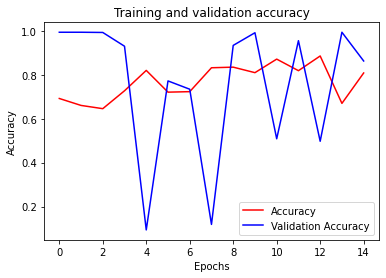

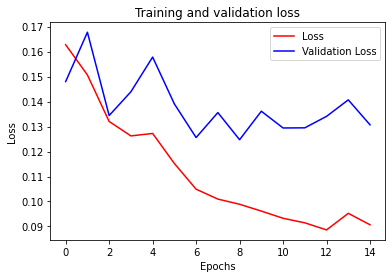

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=model.history.history['accuracy']
val_acc=model.history.history['val_accuracy']
loss=model.history.history['loss']
val_loss=model.history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.show()

In [ ]:
y_pred = model.predict(x_test)
print(y_pred)

[[8.35442636e-03 3.29891278e-04 4.92685661e-03 1.37753508e-04
  4.82519530e-03 1.43745751e-03]
 [6.11696625e-03 2.51696241e-04 2.99456529e-03 2.24118921e-04
  2.86284718e-03 3.00046639e-03]
 [5.22844214e-03 1.47926170e-04 6.61014579e-03 6.04215275e-05
  3.10194935e-03 8.72249994e-03]
 ...
 [1.33601315e-02 2.46164767e-04 5.75582683e-03 2.23406139e-04
  6.03678590e-03 3.13346367e-03]
 [3.15239206e-02 8.25475785e-04 1.36678480e-02 2.83610658e-04
  1.64778866e-02 8.17037188e-03]
 [6.11696625e-03 2.51696241e-04 2.99456529e-03 2.24118921e-04
  2.86284718e-03 3.00046639e-03]]


# Initialisation du modèle pré-entrainé

Hyperparamètres

In [ ]:
embedding_dim = 100    # Dimensions used for glove6b100
max_length = 20        # Maximum size of a tweet

In [ ]:
embeddings_index = {};

with open('/content/drive/MyDrive/RNN_sentiment_dataset/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

Initialisation du modèle

In [ ]:
tf.keras.utils.set_random_seed(123)

model_emb = Sequential(
    [
        tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, input_length=max_length , weights=[embeddings_matrix], trainable=False),
        tf.keras.layers.GRU(64),
        tf.keras.layers.Dense(1,activation='sigmoid'),
    ]
)

Compilation du modèle

In [ ]:
model_emb.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

### Summary du model

In [ ]:
model_emb.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 100)           3301200   
                                                                 
 gru_2 (GRU)                 (None, 64)                31872     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,333,137
Trainable params: 31,937
Non-trainable params: 3,301,200
_________________________________________________________________


# Entrainement du modèle Pre-entrainé

In [ ]:
num_epochs = 15
print(len(x_test))
print(len(x_train))

3989
3989


In [ ]:
save_model2 = tf.keras.callbacks.ModelCheckpoint(
    '/content/model_emb_{epoch:02d}.h5', monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
    options=None, initial_value_threshold=None
)

In [ ]:
def scheduler2(epoch, lr):
  if epoch == 1 :
    return lr
  elif epoch == 5 or epoch == 10:
    return lr * 0.3
  else :
    return lr * np.power(0.99,(epoch / 400))

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
history = model.fit(x_train, 
                      y_train, 
                      epochs=num_epochs, 
                      validation_data=(x_test, y_test),
                      batch_size = 32,
                      verbose=1,
                    callbacks=[save_model2],)
  
print("Training Complete")

Epoch 1/50
125/125 [==============================] - 24s 189ms/step - loss: 0.0883 - accuracy: 0.7909 - val_loss: 0.1316 - val_accuracy: 0.9589
Epoch 2/50
125/125 [==============================] - 23s 183ms/step - loss: 0.0888 - accuracy: 0.8298 - val_loss: 0.1425 - val_accuracy: 0.7543
Epoch 3/50
125/125 [==============================] - 24s 195ms/step - loss: 0.0896 - accuracy: 0.7967 - val_loss: 0.1458 - val_accuracy: 0.7493
Epoch 4/50
125/125 [==============================] - 24s 192ms/step - loss: 0.0886 - accuracy: 0.8072 - val_loss: 0.1376 - val_accuracy: 0.7774
Epoch 5/50
125/125 [==============================] - 24s 190ms/step - loss: 0.0904 - accuracy: 0.7115 - val_loss: 0.1483 - val_accuracy: 0.9822
Epoch 6/50
125/125 [==============================] - 23s 188ms/step - loss: 0.0904 - accuracy: 0.7899 - val_loss: 0.1471 - val_accuracy: 0.8844
Epoch 7/50
125/125 [==============================] - 23s 181ms/step - loss: 0.0874 - accuracy: 0.7939 - val_loss: 0.1441 - val_ac

In [ ]:
y_pred = model_emb.predict()
print(y_pred)
# pb avec le nb 125/125

TypeError: ignored

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_emb=model_emb.history.history['accuracy']
val_acc_emb=model_emb.history.history['val_accuracy']
loss_emb=model_emb.history.history['loss']
val_loss_emb=model_emb.history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc_emb, 'r')
plt.plot(epochs, val_acc_emb, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss_emb, 'r')
plt.plot(epochs, val_loss_emb, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.show()

Comparaison des deux modèles

In [ ]:
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, val_acc_emb, 'r', label='Pretrain')
plt.plot(epochs, val_acc, 'b', label='Train')
plt.title('Validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, val_loss_emb, 'r', label='Pretrain')
plt.plot(epochs, val_loss, 'b', label='Train')
plt.title('Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Tentative de modèle par génération de donnée d'entrainement avec stratified

Le stratified aurait servi

In [ ]:
def create_model() :
  tf.keras.utils.set_random_seed(123)
  model = Sequential(
      [
          tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, input_length=max_length , weights=[embeddings_matrix], trainable=False),
          tf.keras.layers.GRU(64),
          tf.keras.layers.Dense(1,activation='sigmoid'),
      ]
  )
  model_emb.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
  return model


In [ ]:
def train_model(model, xtrain, ytrain, xval, yval):
  history = model.fit(xtrain, ytrain, epochs=num_epochs, 
                      validation_data=(x_test, y_test),
                      batch_size = 32,
                      verbose=1,
                    callbacks=[save_model2],)
  return history

In [ ]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=10, shuffle=True)
# Loop through the indices the split() method returns
y = data.iloc[:,2:8]
print(y[:])
y= [[elm["toxic"], elm["severe_toxic"], elm["obscene"], elm["threat"], elm["insult"], elm["identity_hate"]] for index, elm in y.iterrows()]

# On a eu un problème sur la mise en forme de la donnée ICI 

for index, (train_indices, val_indices) in enumerate(skf.split(x,y)):
    print("Training on fold " + str(index+1) + "/10...")
    # Generate batches from indices
    xtrain, xval = x[train_indices], x[val_indices]
    ytrain, yval = y[train_indices], y[val_indices]
    # Clear model, and create it
    model = None
    model = create_model()
    
    # Debug message I guess
    # print "Training new iteration on " + str(xtrain.shape[0]) + " training samples, " + str(xval.shape[0]) + " validation samples, this may be a while..."
    
    history = train_model(model, xtrain, ytrain, xval, yval)
    accuracy_history = history.history['acc']
    val_accuracy_history = history.history['val_acc']
    print("Last training accuracy: " + str(accuracy_history[-1]) + ", last validation accuracy: " + str(val_accuracy_history[-1]))